# Previsão Perfil de Usuários Aprendizap
A seguir será realizado uma análise dos dados dos professores usuários cadastrados na plataforma do AprendiZap.

**Objetivo:** Criar previsões sobre o perfil dos usuários professores que utilizam o AprendiZap, através de algorítmos de Machine Learning.

##  1.Configurações iniciais

Configuração das bibliotecas e import dos dados.

In [ ]:
!pip install shap
!pip install xgboost

In [62]:
from datetime import datetime, timezone
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import altair as alt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MultiLabelBinarizer, OneHotEncoder
from xgboost import XGBRegressor, plot_importance
import xgboost as xgb
import shap

In [2]:
df_teachers_entries = pd.read_parquet("../data-raw/teachers_entries.parquet")

In [3]:
list(df_teachers_entries.columns)

['unique_id',
 'profid',
 'utm_origin',
 'tela_origem',
 'estado',
 'total_alunos',
 'login_google',
 'currentstage',
 'currentsubject',
 'selectedstages',
 'selectedsubjectsem',
 'selectedsubjectsfundii',
 'visualizou_metodologia_ativa',
 'data_entrada',
 'Recency',
 'Frequency',
 'Duration',
 'R_score',
 'F_score',
 'M_score',
 'RFM_Segment',
 'RFM_Score',
 'semana_entrada']

## 2. Engenharia de Features

### 2.1. Removendo usuários que não foram considerados válidos.
Os usuários considerados válidos serãoo apenas aqueles que preencheram o campo `selectedstages`, em que o professor precisa selecionar se ensinará no Ensino Médio ou Fundamental. É o último campo obrigatório do cadastro, portanto, se não foi um campo completado pelo usuário em cadastro, então assume-se que o usuário nunca utilizou a plataforma realmente.

In [4]:
# filtrar usuários com "selectedstages" sem NA
print(df_teachers_entries.shape)
df_valid_entries=df_teachers_entries[df_teachers_entries['selectedstages'].notna()]
print(df_valid_entries.shape)

(1315970, 23)
(141069, 23)


Observa-se uma redução de 1.315.970 usuários para 141.069.

### 2.2. Removendo Outliers
Foi necessário remover _outliers_ pois foram detectados ao menos 2 usuários com uma utilização anormal da plataforma. Provavelmente BOTS de testes ou outras excesões que podem contaminar o processo.

In [5]:
print(df_valid_entries.shape)
# Remover outliers na coluna "Duration"
limite_inferior = df_valid_entries["Duration"].quantile(0.0001)
limite_superior = df_valid_entries["Duration"].quantile(1 - 0.0001)

# Filtrar dados
df_no_outliers = df_valid_entries[(df_valid_entries["Duration"] >= limite_inferior) & (df_valid_entries["Duration"] <= limite_superior)]
print(df_no_outliers.shape)

(141069, 23)
(141054, 23)


### 2.3. Definindo Escopo inicial
Inicialmente a hipótese primária levará as seguintes colunas em consideração para o modelo de inteligência artificial.

- Colunas desconsideradas para o modelo: `unique_id`,`profid`,`R_Score`,`F_Score`,`M_Score`,`RFM_Segment`,`RFM_Score`,`semana_entrada`.

- Colunas para transformar em preditora categórica: `utm_origin`,`tela_origem`,`login_google`,`estado`,`currentstage`,`currentsubject`,`selectedstages`,`selectedsubjectsem`,`selectedsubjectsfundii`,`visualizou_metodologia_ativa`.

- Colunas para serem normalizadas: `total_alunos`,`Recency`,`Frequency`.

- Coluna alvo: `Duration`.

### 2.4. Ajustando variáveis categóricas
Nesta secção serão regularizadas as colunas categóricas, pois possuem uma série de problemas ao serem analisadas por modelos preditivos. Antes, será plotado uma contagem de todos os dados do dataframe para melhor visualização.

Primeiramente, repara-se que login_google possui 2 categorias que deveriam ser binárias, mas como está registrada como `float`, apenas vemos os casos `True`.
As colunas convertidas são `login_google` e `visualizou_metodologia_ativa`.

In [6]:
# Convertendo login_google e visualizou_metodologia_ativa para booleano
df_categ_step = df_no_outliers.copy()
df_categ_step['login_google'] = df_categ_step['login_google'].apply(lambda x: True if x == 1.0 else False)
df_categ_step['visualizou_metodologia_ativa'] = df_categ_step['visualizou_metodologia_ativa'].apply(lambda x: True if x == 1.0 else False)

Também é visível que em `currentstage` temos categorias redundantes, como por exemplo `em` / `ensino_medio`, e `fundii` / `ensino_fundamental_2`. Portanto essas categorias serão agrupadas.

In [7]:
# Agrupando valores equivalentes em currentstage
df_categ_step['currentstage'] = df_categ_step['currentstage'].replace({
    'ensino_medio': 'em',
    'ensino_fundamental_2': 'fundii'
})

Abaixo é realizado a normalização de colunas `selectedsubjectsem` e `selectedsubjectsfundii`, que são colunas cujos valores são **listas** com as matérias selecionadas por cada professor cadastrado.

Desta forma, o que é necessário, é convertê-las para uma diversidade de linhas booleanas, com True, para as matérias selecionadas.

Exemplo: se um professor está cadastrado nas matérias [1,2,português], será criado 3 colunas `selectedsubjectsem_1`, `selectedsubjectsem_2` e `selectedsubjectsem_português`, nas quais este usuário terá valor `True`.

In [8]:
# Convertendo colunas vazias para listas vazias '[]'.
df_categ_step['selectedsubjectsfundii'] = df_categ_step['selectedsubjectsfundii'].apply(lambda x: x if pd.notna(x) else '[]')
df_categ_step['selectedsubjectsem'] = df_categ_step['selectedsubjectsem'].apply(lambda x: x if pd.notna(x) else '[]')

In [9]:
# Criando função para converter string para lista
def str_to_list(s):
    # remove colchetes e espaços extras
    s_clean = s.strip("[]").replace(" ", "")
    if not s_clean:  # caso esteja vazio
        return []
    # separa por vírgula
    items = s_clean.split(",")
    # tenta converter para int se for número, senão mantém como string
    lista = []
    for i in items:
        lista.append(str(i))
    return lista


# Criando função para expandir colunas de listas em múltiplas colunas booleanas
def expand_str_list_column(df, column):
    
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df[column])
    encoded_df = pd.DataFrame(
        encoded,
        columns=[f"{column}_{str(c)}" for c in mlb.classes_],
        index=df.index
    )
    return pd.concat([df, encoded_df], axis=1)

In [10]:
# Aplicando as funções na coluna selectedsubjectsem
df_categ_step['selectedsubjectsem'] = df_categ_step['selectedsubjectsem'].apply(str_to_list)
df_categ_step = expand_str_list_column(df_categ_step, "selectedsubjectsem")

In [11]:
# Aplicando as funções na coluna selectedsubjectsfundii
df_categ_step['selectedsubjectsfundii'] = df_categ_step['selectedsubjectsfundii'].apply(str_to_list)
df_categ_step = expand_str_list_column(df_categ_step, "selectedsubjectsfundii")

Enfim, todas as colunas categóricas são convertidas em tipos como _category_. Isso será utilizado no pipeline de Machine Learning para criar o One Hot Encoder.

In [12]:
# Convertendo colunas categóricas para o tipo 'category'
cat_cols = ['utm_origin','tela_origem','estado','login_google','currentstage','currentsubject',
            'selectedstages','visualizou_metodologia_ativa']

for col in cat_cols:
    df_categ_step[col] = df_categ_step[col].astype('category')

### 2.5. Ajustando variáveis numéricas
Há 3 variáveis numéricas que precisam de normalizações: `total_alunos`, `Frequency` e `Recency`.

In [13]:
df_num_step = df_categ_step.copy()

Primeiro será tratado o `total_alunos`. Pelo _describe_ observa-se que possui valores negativos e também uma concentração grande de alunos em valores mais baixos, com outliers.

In [14]:
df_num_step['total_alunos'].describe()

count    118816.000000
mean         40.141513
std          68.478662
min         -60.000000
25%          10.000000
50%          30.000000
75%          40.000000
max         999.000000
Name: total_alunos, dtype: float64

In [15]:
# Professores com número negativo de alunos são transformados em 0
df_num_step['total_alunos'] = df_num_step['total_alunos'].apply(lambda x: 0 if x < 0 else x)

In [16]:
# A seguir será aplicado o StandardScaler para normalizar a coluna total_alunos
std_scaler = StandardScaler()
df_num_step['total_alunos_std'] = std_scaler.fit_transform(df_num_step[['total_alunos']])

A seguir, a coluna `Recency` e `Frequency` serão normalizadas:

In [17]:
# A seguir será aplicado o RobustScaler para normalizar as colunas Recency e Frequency
robust_scaler = RobustScaler()
df_num_step['Recency_robust'] = robust_scaler.fit_transform(df_num_step[['Recency']])
df_num_step['Frequency_robust'] = robust_scaler.fit_transform(df_num_step[['Frequency']])

### 2.6. Ajustando variável temporal
A variável temporal precisa ser transformado em uma componente de cíclica de oscilação

In [18]:
df_temp_step = df_num_step.copy()

In [19]:
# Componentes cíclicas para dias da semana (0=segunda, 6=domingo)
df_temp_step['weekday_entrada'] = df_temp_step['data_entrada'].dt.weekday
df_temp_step['weekday_sin_entrada'] = np.sin(2 * np.pi * df_temp_step['weekday_entrada']/7)
df_temp_step['weekday_cos_entrada'] = np.cos(2 * np.pi * df_temp_step['weekday_entrada']/7)

# Componentes cíclicas para meses do ano (1=Janeiro, 12=Dezembro)
df_temp_step['month_entrada'] = df_temp_step['data_entrada'].dt.month
df_temp_step['month_sin_entrada'] = np.sin(2 * np.pi * (df_temp_step['month_entrada']-1)/12)
df_temp_step['month_cos_entrada'] = np.cos(2 * np.pi * (df_temp_step['month_entrada']-1)/12)

Basicamente, a data de entrada do usuário é convertida em 4 colunas mais importantes: dia da semana e mês do ano. Por que isso? Pois os modelos de machine learning não entendem as datas com a periodicidade que as pessoas. Em outras palavras, final de dezembro é bem perto de janeiro, assim como domingo está perto de segunda-feira, mas para o computador, janeiro/dezembro, domingo/segunda, estariam em pontas opostas. Por isso é importante adicionar as componentes cíclicas de Cosseno e Seno.

É importante adicionar tanto a componente Cosseno, tanto quanto a Seno, pois são estas 2 preditoras que criam o ciclo de oscilação do calendário.

### 2.7. Excluindo colunas desnecessárias

In [20]:
# 2.7. Excluindo colunas desnecessárias
cols_to_drop = ['unique_id','profid','R_score','F_score','M_score','RFM_Segment','RFM_Score',
                'semana_entrada','data_entrada','total_alunos','Recency','Frequency',
                'weekday_entrada','month_entrada','selectedsubjectsfundii','selectedsubjectsem']
df_dropped = df_temp_step.drop(columns=cols_to_drop)

In [21]:
df_dropped.columns

Index(['utm_origin', 'tela_origem', 'estado', 'login_google', 'currentstage',
       'currentsubject', 'selectedstages', 'visualizou_metodologia_ativa',
       'Duration', 'selectedsubjectsem_1', 'selectedsubjectsem_2',
       'selectedsubjectsem_3', 'selectedsubjectsem_4', 'selectedsubjectsem_5',
       'selectedsubjectsem_6', 'selectedsubjectsem_7', 'selectedsubjectsem_8',
       'selectedsubjectsem_ciencias', 'selectedsubjectsem_humanas',
       'selectedsubjectsem_linguagens', 'selectedsubjectsem_matematica',
       'selectedsubjectsem_vida', 'selectedsubjectsfundii_1',
       'selectedsubjectsfundii_2', 'selectedsubjectsfundii_3',
       'selectedsubjectsfundii_4', 'selectedsubjectsfundii_5',
       'selectedsubjectsfundii_6', 'selectedsubjectsfundii_7',
       'total_alunos_std', 'Recency_robust', 'Frequency_robust',
       'weekday_sin_entrada', 'weekday_cos_entrada', 'month_sin_entrada',
       'month_cos_entrada'],
      dtype='object')

In [22]:
df_dropped.head()

,utm_origin,tela_origem,estado,login_google,currentstage,currentsubject,selectedstages,visualizou_metodologia_ativa,Duration,selectedsubjectsem_1,...,selectedsubjectsfundii_5,selectedsubjectsfundii_6,selectedsubjectsfundii_7,total_alunos_std,Recency_robust,Frequency_robust,weekday_sin_entrada,weekday_cos_entrada,month_sin_entrada,month_cos_entrada
0,Landing Page,Tela inicial,MG,False,fundii,1,[fundii],False,2.247167,0,...,0,0,0,-0.148220,0.025692,-0.25,0.000000,1.000000,8.660254e-01,0.500000
1,Landing Page,Tela inicial,PE,False,em,5,[em],False,1.371333,0,...,0,0,0,-0.002177,0.245684,-0.25,0.433884,-0.900969,-8.660254e-01,0.500000
2,Landing Page,Tela inicial,MT,False,em,4,"[em, fundii]",False,19.604683,0,...,0,1,0,-0.586351,0.022481,0.25,0.781831,0.623490,5.000000e-01,0.866025
3,Landing Page,Tela inicial,MS,False,fundii,1,"[em, fundii]",False,2.989183,1,...,0,0,0,-0.148220,0.385387,-0.25,0.000000,1.000000,-5.000000e-01,-0.866025
4,Não identificado,Tela inicial,SP,False,fundii,4,[fundii],True,4.288583,0,...,0,0,0,-0.586351,-0.163790,-0.25,-0.974928,-0.222521,1.224647e-16,-1.000000


## 3. M.L. Pipeline: Random Forest Regressor

Neste item será realizado a análise de Machine Learning de alguns modelos:
- RandomForestRegressor

### 3.1. Pré-processamento

Enfim, o pipeline de Machine Learning começa com a separação das colunas entre variáveis categóricas, numéricas, temporais e booleanas.

In [23]:
cat_cols = ['utm_origin','tela_origem','estado','currentstage','currentsubject',
            'selectedstages']
num_cols = ['total_alunos_std','Recency_robust','Frequency_robust']
temp_cols = ['weekday_sin_entrada','weekday_cos_entrada',
             'month_sin_entrada','month_cos_entrada']
bool_cols = ['visualizou_metodologia_ativa','login_google',
       'selectedsubjectsem_1', 'selectedsubjectsem_2',
       'selectedsubjectsem_3', 'selectedsubjectsem_4', 'selectedsubjectsem_5',
       'selectedsubjectsem_6', 'selectedsubjectsem_7', 'selectedsubjectsem_8',
       'selectedsubjectsem_ciencias', 'selectedsubjectsem_humanas',
       'selectedsubjectsem_linguagens', 'selectedsubjectsem_matematica',
       'selectedsubjectsem_vida', 'selectedsubjectsfundii_1',
       'selectedsubjectsfundii_2', 'selectedsubjectsfundii_3',
       'selectedsubjectsfundii_4', 'selectedsubjectsfundii_5',
       'selectedsubjectsfundii_6', 'selectedsubjectsfundii_7']
target_col = 'Duration'

Depois, separamos entre Treino e Teste.

In [ ]:
# Cria X e Y, removendo a coluna target_col de X e atribuindo a coluna target_col a y
X = df_dropped.drop(columns=[target_col])
y = df_dropped[target_col]

# Realiza a separação dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Agora, criamos um transformador. Em variáveis categóricas, ele fará o `OneHotEncoder`. Nas numéricas, a transformação de normalização já foi feita, e nas variáveis temporais e booleanas, tudo já está em ordem.

In [25]:
# Pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),   # opcional, já estão escaladas
        ("temp", "passthrough", temp_cols),
        ("bool", "passthrough", bool_cols)
    ]
)

### 3.2. Criação do Pipeline de M.L.

Abaixo, vemos a criação do pipeline de M.L. de um _Random Forest Regressor_.

In [26]:
modelRFR = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

pipelineRFR = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", modelRFR)
])

Na próxima célula, o modelo é treinado e de fato criado, para posteriormente realizar as previsões com os dados separados para teste.

In [27]:
pipelineRFR.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['utm_origin', 'tela_origem',
                                                   'estado', 'currentstage',
                                                   'currentsubject',
                                                   'selectedstages']),
                                                 ('num', StandardScaler(),
                                                  ['total_alunos_std',
                                                   'Recency_robust',
                                                   'Frequency_robust']),
                                                 ('temp', 'passthrough',
                                                  ['weekday_sin_entrada',
                                                   'weekday_cos_entrada',
                                                   'mont...
                                                   'selectedsubjectsem_linguagens',
                                                   'selectedsubjectsem_matematica',
                                                   'selectedsubjectsem_vida',
                                                   'selectedsubjectsfundii_1',
                                                   'selectedsubjectsfundii_2',
                                                   'selectedsubjectsfundii_3',
                                                   'selectedsubjectsfundii_4',
                                                   'selectedsubjectsfundii_5',
                                                   'selectedsubjectsfundii_6',
                                                   'selectedsubjectsfundii_7'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

Com o modelo de RandomForest Regressor treinado, finalmente, realiza-se a previsão com os dados reservados para teste:

In [28]:
y_pred_RFR = pipelineRFR.predict(X_test)

### 3.3. Métricas de Desempenho do Modelo

Em seguida, calcula-se a média absoluta do erro, o RMSE e o R².

In [29]:
print("MAE:", mean_absolute_error(y_test, y_pred_RFR))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_RFR)))
print("R²:", r2_score(y_test, y_pred_RFR))

MAE: 15.405004921358922
RMSE: 48.451697845742494
R²: 0.8029462666274296


In [30]:
y_mean = np.full_like(y_test, y.mean(), dtype=float)
print("Baseline MAE:", mean_absolute_error(y_test, y_mean))

Baseline MAE: 36.537720301179135


Mean Absolute Error de uma linha média é maior, o que comprova que o modelo é superior do que uma estimativa precária, como a média.

A seguir, um gráfico de y_test (valores reais corretos) VS y_pred_RFR (valores previstos pelo modelo de RandomForestRegressor) é plotado.
Vê-se que a previsão realizada é capaz de realizar boas estimativas, mas há muitos pontos com erros grandes, apesar destes erros possuírem simetria.

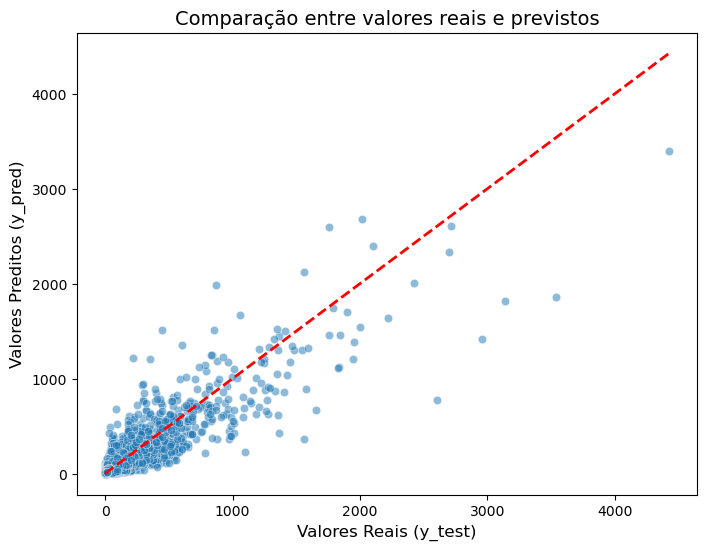

In [31]:
# Previsões
y_pred_RFR = pipelineRFR.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_RFR, alpha=0.5)

# Linha ideal (y = x)
lims = [min(y_test.min(), y_pred_RFR.min()), max(y_test.max(), y_pred_RFR.max())]
plt.plot(lims, lims, 'r--', lw=2)

plt.xlabel("Valores Reais (y_test)", fontsize=12)
plt.ylabel("Valores Preditos (y_pred)", fontsize=12)
plt.title("Comparação entre valores reais e previstos", fontsize=14)
plt.show()

Um outro gráfico de validação da confiabilidade do modelo preditivo é o gráfico Residual Plot. O objetivo deste gráfico é verificar se os erros estão igualmente distribuídos acima e abaixo da linha vermelha (0). Se não estiverem distribuídos simétricamente , indica que o modelo pode estar inviesado, ou ter _Data Leakage_. Neste caso, parece existir uma boa distribuição. Mas percebe-se erros bem elevados.

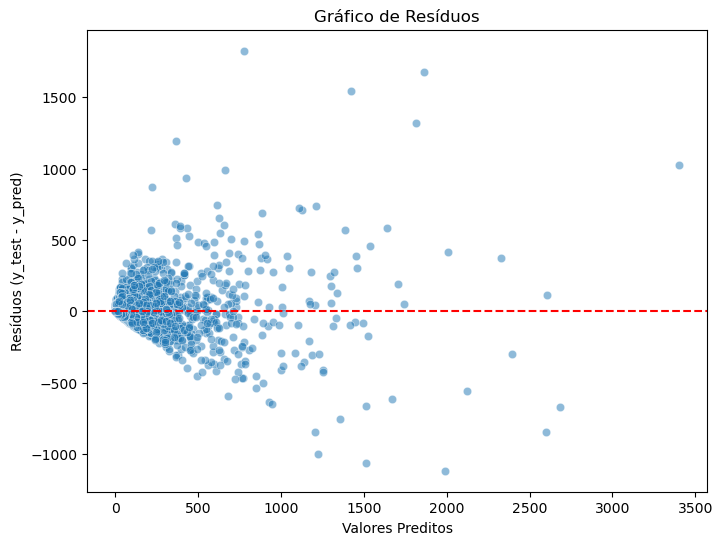

In [39]:
residuos = y_test - y_pred_RFR

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_RFR, y=residuos, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos (y_test - y_pred)")
plt.title("Gráfico de Resíduos")
plt.show()

Agora, será realizado um cross-validation para verificar se o Erro quadrático médio é similar. Isso garante que a amostra de teste/treino não capturaram algum padrão por acaso. Percebe-se que o erro quadrático se mantém constante nos _Folds_, o que indica que não houve viés provocado pela forma como as amostras de treino/teste foram criadas.

In [38]:
scores = cross_val_score(pipelineRFR, X, y, cv=5, scoring="r2")
print("R² médio (CV):", scores.mean())
print("R² por fold:", scores)

R² médio (CV): 0.8199758357101242
R² por fold: [0.83235886 0.80864812 0.80232327 0.82720588 0.82934306]


### 3.4. Cross Validation para Hiperparâmetros


**Atenção!**: Como esta etapa é demorada, está comentada (leva cerca de 30 minutos). Na última execução, foi obtido:

Melhores parâmetros:
- 'model__max_depth': 10,
- 'model__min_samples_split': 10,
- 'model__n_estimators': 500

Resultado: Melhor R² de validação: 0.823681691254534

Percebe-se que o R² da interação inicial foi inferior do que o da validação cruzada. Portanto, será mantido os valores da iteração inicial.

In [32]:
'''
param_grid = {
    "model__n_estimators": [100, 200, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10]
}

search = GridSearchCV(pipeline, param_grid, cv=3, scoring="r2", n_jobs=-1)
search.fit(X_train, y_train)

print("Melhores parâmetros:", search.best_params_)
print("Melhor R² de validação:", search.best_score_)
'''

'\nparam_grid = {\n    "model__n_estimators": [100, 200, 500],\n    "model__max_depth": [None, 10, 20],\n    "model__min_samples_split": [2, 5, 10]\n}\n\nsearch = GridSearchCV(pipeline, param_grid, cv=3, scoring="r2", n_jobs=-1)\nsearch.fit(X_train, y_train)\n\nprint("Melhores parâmetros:", search.best_params_)\nprint("Melhor R² de validação:", search.best_score_)\n'

importances = search.best_estimator_["model"].feature_importances_
feature_names = search.best_estimator_["preprocess"].get_feature_names_out()

feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_importances.head(20))

### 3.5. Interpretabilidade

Caso você tenha habilitado o GridSearchCV, utilize a próxima célula de código para encontrar os hiperparâmetros adequados. Caso contrário, pule para a próxima célula.

In [33]:
'''
importances = search.best_estimator_["model"].feature_importances_
feature_names = search.best_estimator_["preprocess"].get_feature_names_out()

feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_importances.head(20))
'''

'\nimportances = search.best_estimator_["model"].feature_importances_\nfeature_names = search.best_estimator_["preprocess"].get_feature_names_out()\n\nfeat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)\nprint(feat_importances.head(20))\n'

Caso você tenha incorporado o modelo Random Forest com os parâmetros iniciais, utilize as linhas de código abaixo. Aqui é calculado a improtância no modelo de M.L. de cada preditora, seja booleana, temporal, categórica ou numérica. E em seguida, um gráfico será apresentado demonstrando essa importância.

In [34]:
# Acessa o modelo RandomForest já treinado
modelRFR = pipelineRFR["model"]

# Pega as importâncias das features
importances = modelRFR.feature_importances_

# Recupera os nomes das features após transformação
feature_names = pipelineRFR["preprocess"].get_feature_names_out()

# Junta em um DataFrame ou Series para análise
feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_importances.head(20))


num__Frequency_robust                 0.846527
num__Recency_robust                   0.029287
num__total_alunos_std                 0.015441
temp__weekday_sin_entrada             0.006943
temp__month_cos_entrada               0.006605
temp__month_sin_entrada               0.006587
temp__weekday_cos_entrada             0.004834
bool__visualizou_metodologia_ativa    0.003701
cat__estado_CE                        0.002905
cat__estado_MG                        0.002282
cat__estado_SP                        0.002182
cat__utm_origin_SEO Ads               0.002075
cat__estado_PA                        0.002036
cat__selectedstages_[em, fundii]      0.001970
cat__estado_MS                        0.001860
cat__utm_origin_SEO Orgânico          0.001846
bool__login_google                    0.001750
cat__currentsubject_2                 0.001723
bool__selectedsubjectsfundii_6        0.001721
cat__utm_origin_Landing Page          0.001692
dtype: float64


Plotando um gráfico com as 20 features mais importantes para o modelo RandomForest

C:\Users\ericl\AppData\Local\Temp\ipykernel_4044\3711518734.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


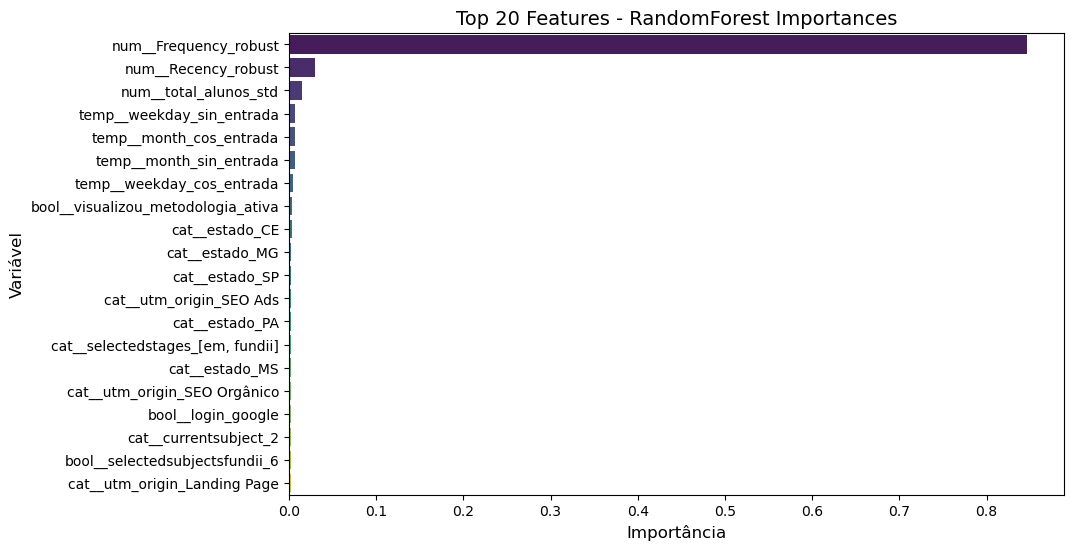

In [35]:
# Seleciona as 20 features mais importantes
top_features = feat_importances.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")

plt.title("Top 20 Features - RandomForest Importances", fontsize=14)
plt.xlabel("Importância", fontsize=12)
plt.ylabel("Variável", fontsize=12)
plt.show()

## 4. M.L. Pipeline: XGBoost

### 4.1. Criação do Pipeline de M.L.

In [50]:
modelXGB = XGBRegressor(
    n_estimators=500,      # número de árvores
    learning_rate=0.05,    # taxa de aprendizado
    max_depth=6,           # profundidade das árvores
    subsample=0.8,         # fração de amostras por árvore
    colsample_bytree=0.8,  # fração de features por árvore
    random_state=42,
    n_jobs=-1
)

pipelineXGB = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", modelXGB)
])

In [51]:
pipelineXGB.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['utm_origin', 'tela_origem',
                                                   'estado', 'currentstage',
                                                   'currentsubject',
                                                   'selectedstages']),
                                                 ('num', StandardScaler(),
                                                  ['total_alunos_std',
                                                   'Recency_robust',
                                                   'Frequency_robust']),
                                                 ('temp', 'passthrough',
                                                  ['weekday_sin_entrada',
                                                   'weekday_cos_entrada',
                                                   'mont...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [52]:
y_pred_XGB = pipelineXGB.predict(X_test)

### 4.2. Métricas de Desempenho do Modelo

Abaixo, calcula-se as métricas R² e RMSE do novo modelo preditivo treinado _XGBoost_. Observa-se que o R² é um pouco melhor do que o do _Random Forest Regressor_. Contudo, há um aumento substancial do RMSE. Ao final do projeto uma tabela comparativa será apresentada.

In [ ]:
print("R²:", r2_score(y_test, y_pred_XGB))
print("RMSE:", mean_squared_error(y_test, y_pred_XGB, squared=False))

R²: 0.7191430744257019
RMSE: 57.84412224413995


c:\Users\ericl\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Assim como no _Random Forest Regressor_, será plotado um gráfico `y_pred`vs `y_teste`, para analisar o quão distante a dispersão está da diagonal, e portanto o erro.

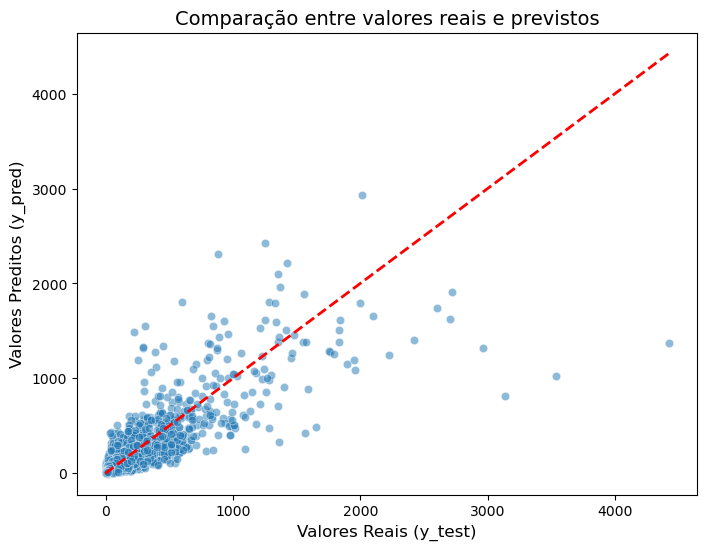

In [59]:
# Previsões
y_pred_XGB = pipelineXGB.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_XGB, alpha=0.5)

# Linha ideal (y = x)
lims = [min(y_test.min(), y_pred_XGB.min()), max(y_test.max(), y_pred_XGB.max())]
plt.plot(lims, lims, 'r--', lw=2)

plt.xlabel("Valores Reais (y_test)", fontsize=12)
plt.ylabel("Valores Preditos (y_pred)", fontsize=12)
plt.title("Comparação entre valores reais e previstos", fontsize=14)
plt.show()

Ao contrário do Random Forest Regressor, o XGBoost parece trazer um pouco mais de assimetria no Residual Plot, conforme o gráfico abaixo. Isso pode não só indicar um enviezamento, como também justifica um **RMSE** um pouco maior.

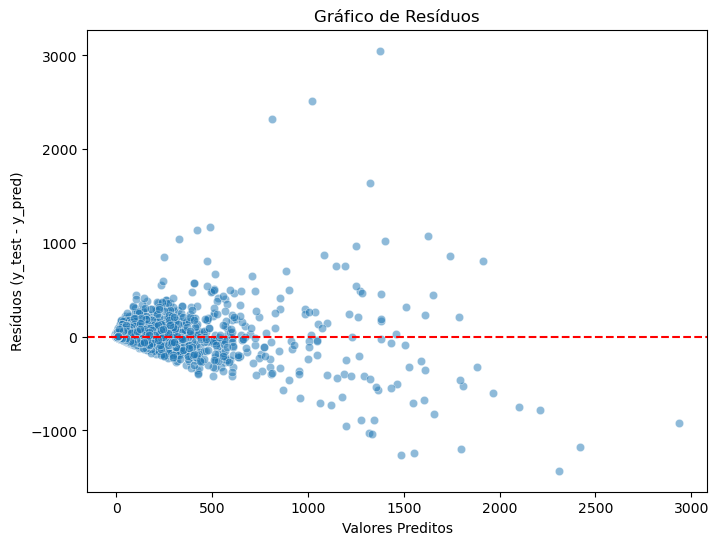

In [61]:
residuos = y_test - y_pred_XGB

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_XGB, y=residuos, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos (y_test - y_pred)")
plt.title("Gráfico de Resíduos")
plt.show()

### 4.3. Cross-validation para Hiperparâmetro

Abaixo, realiza-se um cross validation com 42 camadas. Observa-se um RMSE baixo. O _Test-RMSE-Mean_ está acima do RMSE do treino, indicando que já está no ponto ótimo. Além disso, vemos que o RMSE reduz muito pouco, indicando que por volta da rodada 40, o modelo já está saturado e treiná-lo mais pode provocar overfitting.

In [63]:
# Criar DMatrix com enable_categorical se tiver colunas categóricas
dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)

params = {
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42
}

# Cross-validation com 5 folds
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    nfold=5,
    metrics="rmse",
    early_stopping_rounds=20,
    seed=42
)

print(cv_results.tail())

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
38        36.210765        0.345580       55.054905       3.620299
39        35.983877        0.402439       55.016695       3.600362
40        35.661139        0.409514       55.005593       3.692138
41        35.579796        0.384595       55.021731       3.688409
42        35.353981        0.360738       54.995069       3.743100


### 4.4. Interpretabilidade

**Abaixo realiza-se um plot do gráfico SHAP, de interpretabilidade do modelo XGBoost.**

Cada linha é uma feature do modelo. A ordem é da mais importante (topo) para a menos importante (embaixo). Valores positivos (direita) empurram a previsão para cima (↑). Valores negativos (esquerda) empurram a previsão para baixo (↓). Quanto a cor: Azul → valor baixo daquela variável.Vermelho → valor alto daquela variável. Cada ponto é uma observação (linha do seu dataset).

A dispersão mostra a variação do efeito daquela variável entre os registros.

**O que pode-se concluir:**
- As variáveis de engajamento direto (Frequency, Recency, visualizou_metodologia_ativa) são as mais fortes preditoras.

- Variáveis de origem de tráfego também influenciam, mas menos.

- Variáveis temporais e matérias selecionadas têm impacto, mas pequeno.

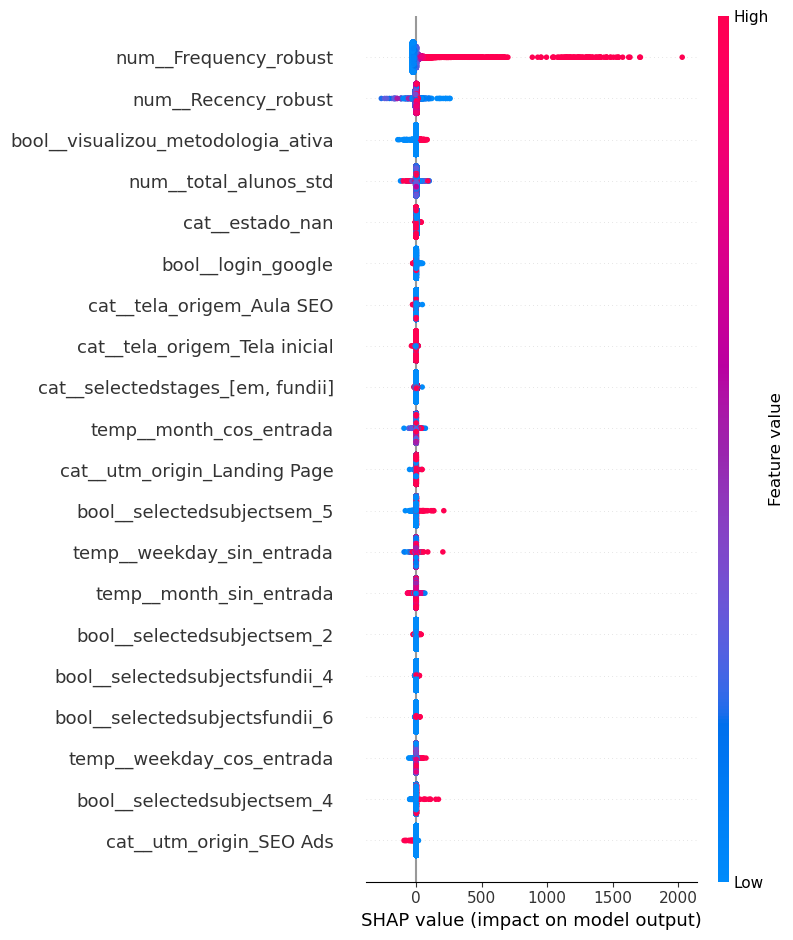

In [58]:
# Explicador baseado no modelo treinado
explainer = shap.TreeExplainer(modelXGB)

# Transformar X_test com o pipeline antes de passar para o SHAP
X_test_transformed = preprocessor.transform(X_test)

# Calcular os valores SHAP
shap_values = explainer.shap_values(X_test_transformed)

# Plotar resumo
shap.summary_plot(shap_values, X_test_transformed, feature_names=preprocessor.get_feature_names_out())